In [1]:
import pandas as pd

In [2]:
eviction_data = pd.read_csv('reference/eviction_data.csv', low_memory=False)

In [3]:
eviction_data = eviction_data.dropna(subset=['Eviction Notice Source Zipcode'], axis=0).reset_index(drop=True)
eviction_data = eviction_data.loc[(eviction_data['Eviction Notice Source Zipcode'] != '941??') & 
                                  (eviction_data['Eviction Notice Source Zipcode'] != '941 1') , :]
eviction_data['Eviction Notice Source Zipcode'] = eviction_data['Eviction Notice Source Zipcode'].astype(int)
eviction_data = eviction_data.loc[eviction_data['Eviction Notice Source Zipcode'] > 90000 , :]
eviction_group_zipcode = eviction_data.groupby(['Eviction Notice Source Zipcode'])['Eviction Notice Source Zipcode'].count()

In [ ]:
eviction_data['File Date'] = pd.to_datetime(eviction_data['File Date'])
eviction_data = eviction_data.sort_values(by=['File Date']).reset_index(drop=True)
eviction_data['year'] = eviction_data['File Date'].dt.year
eviction_data['month'] = eviction_data['File Date'].dt.month

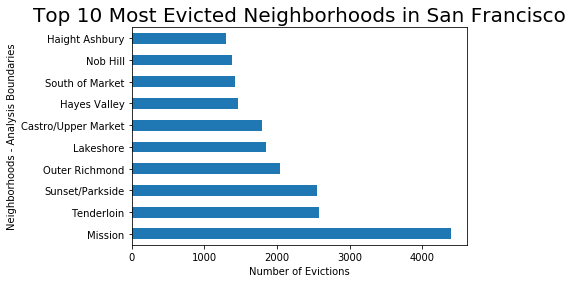

In [30]:
eviction_data = eviction_data.dropna(subset=['Neighborhoods - Analysis Boundaries'], axis=0).reset_index(drop=True)
eviction_group_neighborhood = eviction_data.groupby(['Neighborhoods - Analysis Boundaries'])['Neighborhoods - Analysis Boundaries'].count()
_ = plt.title('Top 10 Most Evicted Neighborhoods in San Francisco', fontsize=20)
_ = plt.xlabel('Number of Evictions')
_ = eviction_group_neighborhood.nlargest(10).plot(kind='barh')
plt.show()

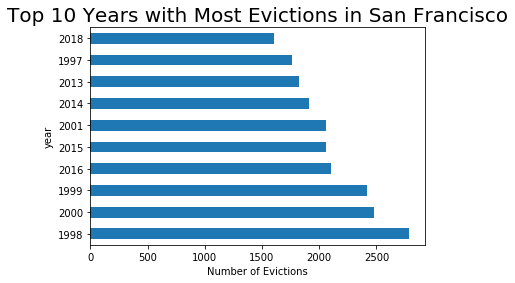

In [29]:
eviction_data = eviction_data.dropna(subset=['year'], axis=0).reset_index(drop=True)
eviction_group_neighborhood = eviction_data.groupby(['year'])['year'].count()
_ = plt.title('Top 10 Years with Most Evictions in San Francisco', fontsize=20)
_ = plt.xlabel('Number of Evictions')
_ = eviction_group_neighborhood.nlargest(10).plot(kind='barh')
plt.show()

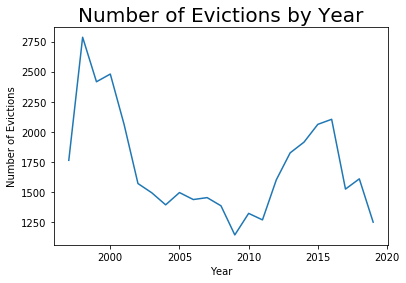

In [31]:
eviction_group_date = eviction_data.groupby(['year'])['year'].count()
_ = plt.title('Number of Evictions by Year', fontsize=20)
_ = plt.xlabel('Year')
_ = plt.ylabel('Number of Evictions')
plt.plot(eviction_group_date.index, eviction_group_date.values)
plt.show()

---

In [8]:
'''
eviction_agg takes the eviction_df from the json file and performs a count aggregate over the desired time difference
'''
def eviction_agg(eviction_df, t):
    # Initialize the eviction counts DataFrame
    eviction_counts_df = pd.DataFrame(columns=['start_time', 'end_time', 'counts'])
    # Initialize tracking variables
    eviction_counts_idx = 0
    count = 0
    start = end = eviction_df.loc[0, 'File Date']
    for row in eviction_df.iterrows():
        end = row[1]['File Date']
        # Get the time difference between start and end points
        delta = end - start
        # Reassign end_time and count if the time difference is less than the time delta
        if delta < t:
            end_time = end
            count += 1
        # Add the count to a row of eviction_counts if the time difference is greater than or equal to time delta
        elif delta >= t and start != end:
            # Add a row to the eviction_counts dataframe if the count of evictions is non-zero between time points
            if count != 0:
                eviction_counts_df.loc[eviction_counts_idx] = [start] + [end_time] + [count]
            start = end
            eviction_counts_idx += 1
            count = 0
    return eviction_counts_df

In [9]:
'''
plot_time_period accepts the formatted aggregated count DataFrame returned from eviction_df and plots the
given number of cycles from the DataFrame in separate plots with a specified number of points per subplot
'''
def plot_time_period(agg_df, cycles, num_points, title, xlabel, dt_format, figsize=(10,10)):
    fig, axs = plt.subplots(cycles, 1, figsize=figsize)
    if cycles > 1:
        for i in range(cycles):
            # Create a list of string formatted datetimes over the course of a cycle
            date_time_list = []
            for dt in agg_df.start_time[num_points*i:num_points*(i+1)]:
                date_time = dt.strftime(dt_format)
                date_time_list.append(date_time)
            # Use datetime strings as xtick labels
            _ = axs[i].plot(date_time_list, agg_df.counts[num_points*i:num_points*(i+1)])
            _ = axs[i].set_xticklabels(date_time_list, rotation=45)
    else:
        # Format date times into string
        date_time_list = []
        for dt in agg_df.start_time[0:num_points]:
            date_time = dt.strftime(dt_format)
            date_time_list.append(date_time)
        # Use datetime strings as x tick labels
        _ = axs.plot(date_time_list, agg_df.counts[0:num_points])
        _ = axs.set_xticklabels(date_time_list, rotation=45)
    _ = plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1)
    _ = fig.suptitle(title, y=1.05, fontsize=20)
    fig.text(0.5, -0.03, xlabel, ha='center', fontsize=16)
    fig.text(-0.03, 0.5, 'Number of Evictions', va='center', rotation='vertical', fontsize=16)
    plt.show()

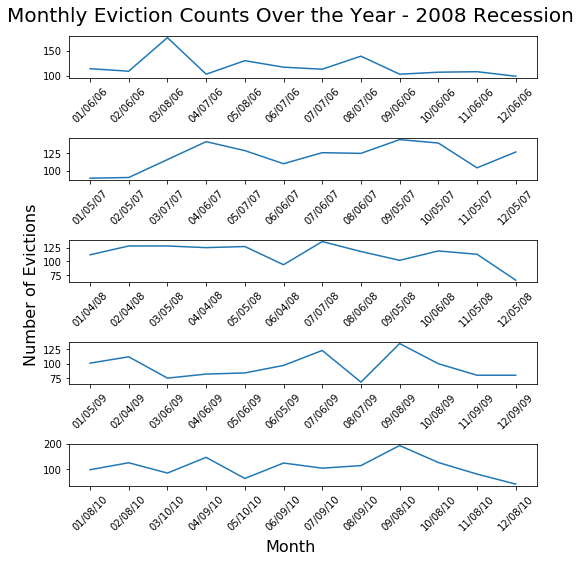

In [11]:
# Aggregate evictions over 30 day time periods for the 2008 Recession
t = pd.Timedelta('720:00:00')
monthly_agg_df = eviction_agg(eviction_data, t)
monthly_agg_df = monthly_agg_df.loc[(monthly_agg_df.start_time.dt.year >= 2006) & (monthly_agg_df.start_time.dt.year <= 2010), :]

# Plot the monthly eviction counts over the course of a year for 5 years
cycles = 5
num_points = 12
title = 'Monthly Eviction Counts Over the Year - 2008 Recession'
xlabel = 'Month'
dt_format = "%m/%d/%y"
_ = plot_time_period(monthly_agg_df, cycles, num_points, title, xlabel, dt_format, figsize=(7, 7))

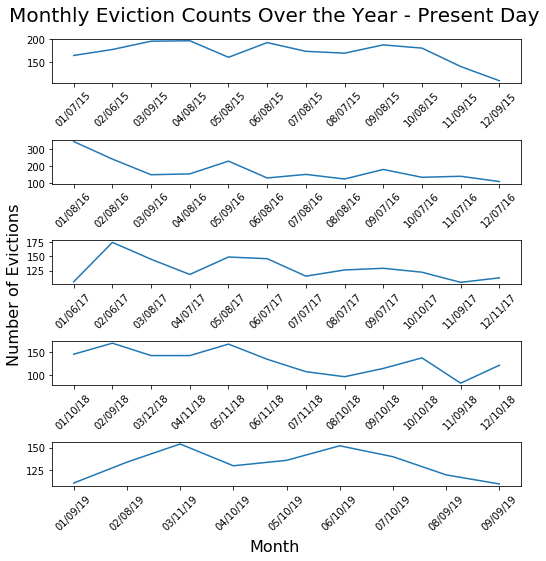

In [12]:
# Aggregate evictions over 30 day time periods for Present Day
t = pd.Timedelta('720:00:00')
monthly_agg_df = eviction_agg(eviction_data, t)
monthly_agg_df = monthly_agg_df.loc[(monthly_agg_df.start_time.dt.year >= 2015), :]

# Plot the monthly eviction counts over the course of a year for 5 years
cycles = 5
num_points = 12
title = 'Monthly Eviction Counts Over the Year - Present Day'
xlabel = 'Month'
dt_format = "%m/%d/%y"
_ = plot_time_period(monthly_agg_df, cycles, num_points, title, xlabel, dt_format, figsize=(7, 7))

---

---

In [13]:
# Aggregate the DataFrame by neighborhood and year
agg_df = pd.DataFrame()
agg_df['num_evictions'] = eviction_data.groupby(['Neighborhoods - Analysis Boundaries', 'year'])['Neighborhoods - Analysis Boundaries'].count()
agg_df = agg_df.reset_index()
agg_df.head()

,Neighborhoods - Analysis Boundaries,year,num_evictions
0,Bayview Hunters Point,1997,20
1,Bayview Hunters Point,1998,52
2,Bayview Hunters Point,1999,68
3,Bayview Hunters Point,2000,80
4,Bayview Hunters Point,2001,62


In [14]:
# Establish the True/False boolean columns
bool_columns = ['Breach', 'Nuisance', 'Illegal Use', 'Failure to Sign Renewal', 'Access Denial',
               'Unapproved Subtenant', 'Owner Move In', 'Demolition', 'Capital Improvement', 'Substantial Rehab',
               'Ellis Act WithDrawal', 'Roommate Same Unit', 'Other Cause', 'Late Payments', 'Lead Remediation',
               'Development', 'Good Samaritan Ends']
eviction_data[bool_columns] = eviction_data[bool_columns].astype(str)

# One Hot Encode True/False data
cat_eviction_data = eviction_data[bool_columns]
cat_eviction_data = pd.get_dummies(cat_eviction_data, prefix_sep='_')

# Add the neighborhoods and year information
cat_eviction_data['Neighborhoods - Analysis Boundaries'] = eviction_data['Neighborhoods - Analysis Boundaries']
cat_eviction_data['year'] = eviction_data['year']

# Aggregate the one hot encoded columns
ex = cat_eviction_data.groupby(['Neighborhoods - Analysis Boundaries', 'year']).sum().astype(int)
ex = ex.reset_index()

# Merge the aggregated boolean columns to the agg_df
agg_df = agg_df.merge(ex, on=['Neighborhoods - Analysis Boundaries', 'year'])
agg_df.head()

,Neighborhoods - Analysis Boundaries,year,num_evictions,Breach_False,Breach_True,Nuisance_False,Nuisance_True,Illegal Use_False,Illegal Use_True,Failure to Sign Renewal_False,...,Other Cause_False,Other Cause_True,Late Payments_False,Late Payments_True,Lead Remediation_False,Lead Remediation_True,Development_False,Development_True,Good Samaritan Ends_False,Good Samaritan Ends_True
0,Bayview Hunters Point,1997,20,15,5,16,4,19,1,20,...,17,3,19,1,20,0,20,0,20,0
1,Bayview Hunters Point,1998,52,43,9,44,8,52,0,52,...,49,3,50,2,52,0,52,0,52,0
2,Bayview Hunters Point,1999,68,56,12,63,5,68,0,68,...,67,1,59,9,68,0,68,0,68,0
3,Bayview Hunters Point,2000,80,64,16,77,3,79,1,80,...,63,17,78,2,80,0,80,0,80,0
4,Bayview Hunters Point,2001,62,54,8,55,7,57,5,62,...,60,2,61,1,62,0,62,0,62,0


---

In [ ]:
max_col = ''
max_prop = 0

for bool_col in bool_columns:
    grouped_count = cat_eviction_data.groupby(bool_col)[bool_col].count()
    grouped_proportion = grouped_count['True'] / (grouped_count['True'] + grouped_count['False'])
    if grouped_proportion > max_prop:
        max_prop = grouped_proportion
        max_col = bool_col
max_col, max_prop

In [ ]:
bool_columns.remove('Owner Move In')
bool_df = eviction_data[bool_columns]
cat_eviction_data = pd.get_dummies(bool_df, prefix_sep='_')
cat_eviction_data['Owner Move In'] = eviction_data['Owner Move In'].astype(str)
cat_eviction_data.head()

In [ ]:
# Matrix for actual values of categories grouped by the fact that the owner moved in
cat_comparison = cat_eviction_data.groupby('Owner Move In').sum().astype(int)

# Matrix for expected values of categories grouped by the fact that the owner moved in
from scipy.stats import chi2_contingency
chi2_cont = chi2_contingency(cat_comparison.values)
exp = pd.DataFrame(data=chi2_cont[3].astype(int), columns=cat_comparison.columns, index=cat_comparison.index)

# Contingency table matrix comparing actual values to expected values
cont_table = (cat_comparison.values - exp.values)/exp.values
cont_table = pd.DataFrame(data=cont_table, columns=cat_comparison.columns, index=cat_comparison.index)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

non_payment_cont_val = pd.Series(cont_table.loc['True'], index=cont_table.columns)
non_payment_cont_val = non_payment_cont_val[non_payment_cont_val > 0]
_ = plt.title('Top 20 Deviation Values for SF Tenants that Were Evicted By Owner Move In', fontsize=20)
_ = plt.ylabel('Feature')
_ = plt.xlabel('Deviation Value')
_ = non_payment_cont_val.nlargest(20).plot(kind='barh')
plt.show()

In [ ]:
actual_breach = cat_comparison.loc['True', 'Breach_False']
exp_breach = exp.loc['True', 'Breach_False']
chi_square_breach = cont_table.loc['True', 'Breach_False']

print('EXAMPLE DEVIATION VALUE')
print(f'Actual Number for Tenants that Didn\'t Breach Contract & Owner Moved In: {int(actual_breach)}')
print(f'Expected Number for Tenants that Didn\'t Breach Contract & Owner Moved In: {int(exp_breach)}')
print(f'Contingency Value for Tenants that Didn\'t Breach Contract & Owner Moved In: {chi_square_breach:.2f}')

---

In [ ]:
cat_eviction_data = eviction_data[bool_columns]
col_list = []
prop_list = []

for bool_col in bool_columns:
    grouped_count = cat_eviction_data.groupby(bool_col)[bool_col].count()
    grouped_proportion = grouped_count['True'] / (grouped_count['True'] + grouped_count['False'])
    col_list.append(bool_col)
    prop_list.append(grouped_proportion)
# Python code to demonstrate 
# sort zipped list by values 
# using lambda and sorted 
  
zipped = list(zip(col_list, prop_list)) 

# Using sorted and lambda 
res = sorted(zipped, key = lambda x: x[1])
res = list(reversed(res))
      
# printing result 
print("final list - ", str(res)) 

In [ ]:
bool_columns.append('Owner Move In')
bool_columns.remove('Breach')
bool_df = eviction_data[bool_columns]
cat_eviction_data = pd.get_dummies(bool_df, prefix_sep='_')
cat_eviction_data['Breach'] = eviction_data['Breach'].astype(str)
cat_eviction_data.head()

In [ ]:
# Matrix for actual values of categories grouped by the fact that the owner moved in
cat_comparison = cat_eviction_data.groupby('Breach').sum().astype(int)

# Matrix for expected values of categories grouped by the fact that the owner moved in
from scipy.stats import chi2_contingency
chi2_cont = chi2_contingency(cat_comparison.values)
exp = pd.DataFrame(data=chi2_cont[3].astype(int), columns=cat_comparison.columns, index=cat_comparison.index)

# Contingency table matrix comparing actual values to expected values
cont_table = (cat_comparison.values - exp.values)/exp.values
cont_table = pd.DataFrame(data=cont_table, columns=cat_comparison.columns, index=cat_comparison.index)
cont_table

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

non_payment_cont_val = pd.Series(cont_table.loc['True'], index=cont_table.columns)
non_payment_cont_val = non_payment_cont_val[non_payment_cont_val > 0]
_ = plt.title('Top 20 Deviation Values for SF Tenants that Were Evicted By Contract Breach', fontsize=20)
_ = plt.ylabel('Feature')
_ = plt.xlabel('Deviation Value')
_ = non_payment_cont_val.nlargest(20).plot(kind='barh')
plt.show()